In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane_cirq import ops as cirq_ops

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split, random_state=42)

In [3]:
import time
timestr = time.strftime("%d%m%Y")
tag = str("noisyQNN3-"+timestr)

Params in the quantum layer to train: 3
0: ──RX(0.02)─╭●──────────╭X──AmplitudeDamp(0.10)──RX(0.07)─╭●──────────────BitFlip(0.10)
1: ──RX(0.50)─╰X─╭●───────│───AmplitudeDamp(0.10)──RX(0.24)─├●─────────────╭●────────────
2: ──RX(0.09)────╰X─╭●────│───AmplitudeDamp(0.10)──RX(0.65)─╰X─────────────├●────────────
3: ──RX(1.00)───────╰X─╭●─│───AmplitudeDamp(0.10)──RX(0.64)────────────────╰X────────────
4: ──RX(0.24)──────────╰X─╰●──AmplitudeDamp(0.10)──RX(0.33)──BitFlip(0.10)───────────────

────────────────────╭X─╭●─╭●──────────────────────────────────────╭RX(0.11)──PhaseFlip(0.10)
───BitFlip(0.10)────│──├X─╰RX(0.50)─╭●────────────────────────────│──────────PhaseFlip(0.10)
───BitFlip(0.10)─╭●─│──│────────────╰RX(0.01)─╭●──────────────────│──────────PhaseFlip(0.10)
───BitFlip(0.10)─├●─├●─│──────────────────────╰RX(0.73)─╭●────────│──────────PhaseFlip(0.10)
─────────────────╰X─╰●─╰●───────────────────────────────╰RX(0.44)─╰●─────────PhaseFlip(0.10)

──╭●──────────────────────────────────────╭

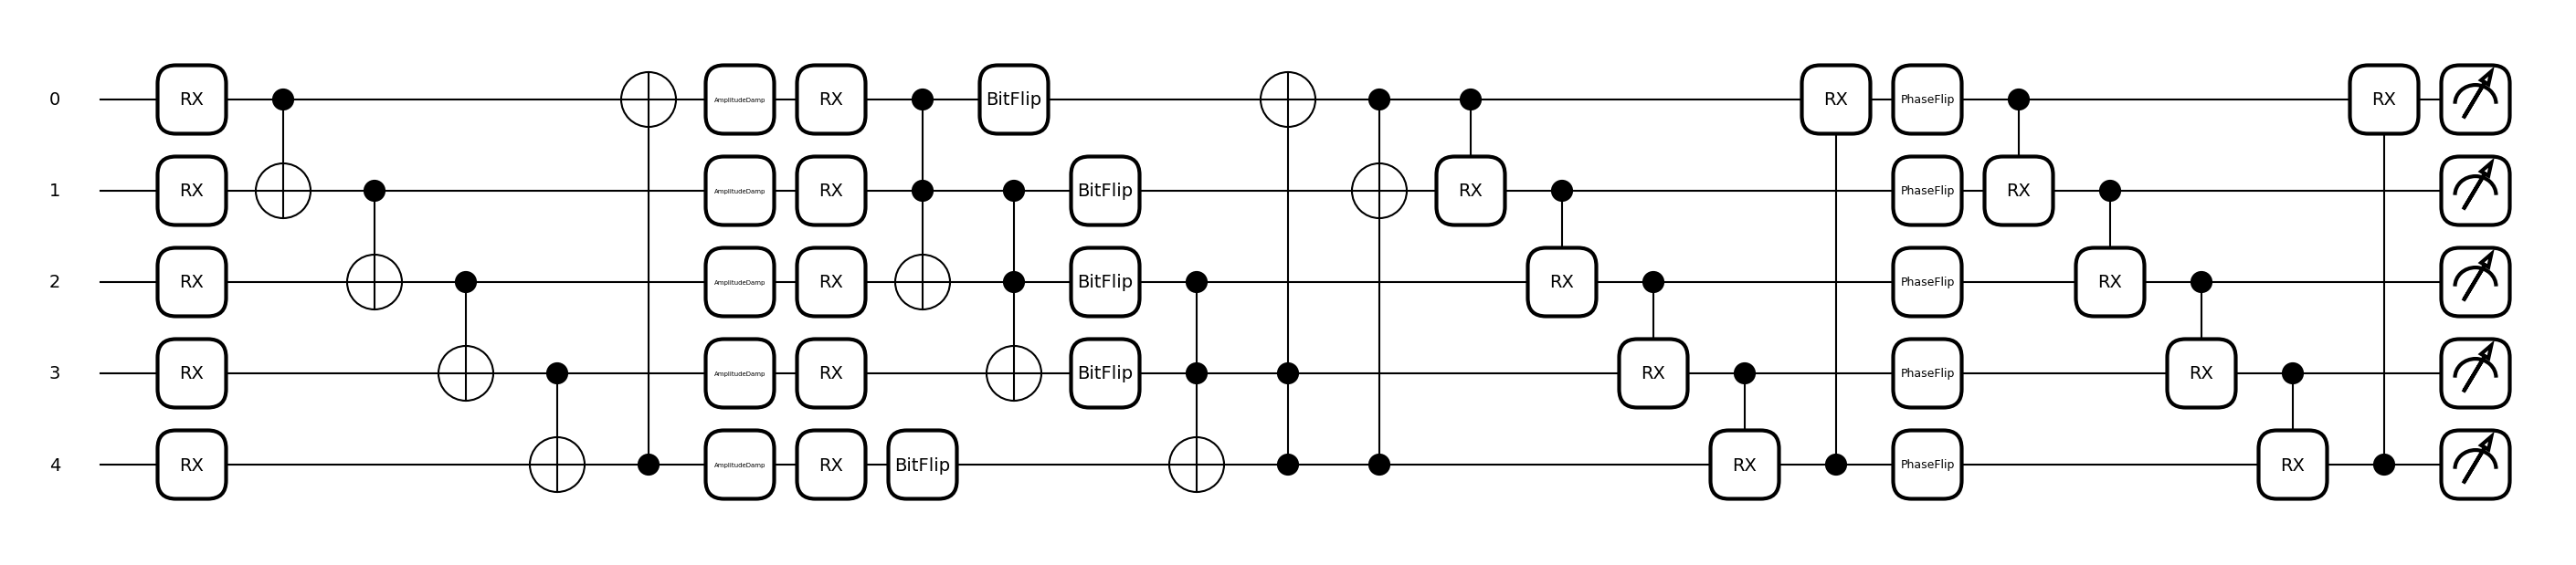

In [7]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
params = 3
# p_noise = 0.1*np.ones((n_qubits))
weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits),
                 "weight3": (n_qubits)}
                #  "p_noise": (n_qubits)}
n_qcParams = len(weight_shapes)
print(f"Params in the quantum layer to train: {n_qcParams}")

dev = qml.device("cirq.mixedsimulator", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weight1, weight2, weight3):
    p_noise = [0.1,0.1,0.1,0.1,0.1]
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    
    qml.broadcast(cirq_ops.AmplitudeDamp, wires=range(n_qubits), parameters=p_noise, pattern="single")
    
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.Toffoli(wires=[0,1,2])
    qml.Toffoli(wires=[1,2,3])
    
    qml.broadcast(cirq_ops.BitFlip, wires=range(n_qubits), parameters=p_noise, pattern="single")
    
    qml.Toffoli(wires=[2,3,4])
    qml.Toffoli(wires=[3,4,0])
    qml.Toffoli(wires=[4,0,1])
    
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight2, pattern="ring")
    qml.broadcast(cirq_ops.PhaseFlip, wires=range(n_qubits), parameters=p_noise, pattern="single")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight3,  pattern="ring")
       
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits))
plt.show()
fig.savefig("archive/Qnode-"+tag+".png")
fig.savefig("archive/Qnode-"+tag+".pdf")

In [8]:
#Create a simple ANN
import numpy as np
clear_session()
tf.keras.backend.set_floatx('float64')
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()

Params in the quantum layer to train: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2, momentum=0.5)

ann.compile(optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=30, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/30
 1/31 [..............................] - ETA: 59:10 - loss: 16149.6093 - mean_absolute_error: 126.8808

In [ ]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)

In [ ]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])
ann.summary()

In [ ]:
ann.save("archive/model-"+tag+".h5")
ann.save_weights("archive/weights-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)